**Library Installation Part**

In [ ]:
#NOTHING
import torch
from torchvision.datasets import FakeData
from torchvision.transforms import v2

**Import Library**

In [ ]:
# baseline cnn model for fashion mnist
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

**Fashion MNIST Clothing Data Exploration**

4422102/4422102 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


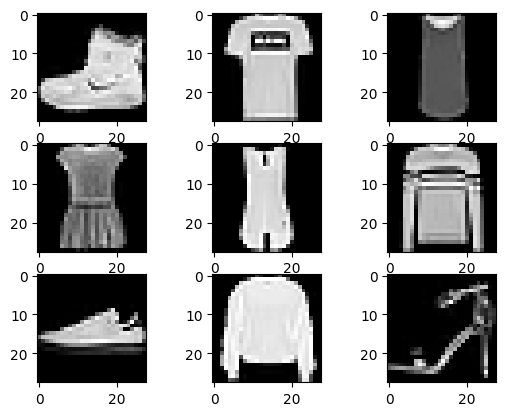

In [ ]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from keras.datasets import fashion_mnist
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

**Data Augmentation Testing**

Basic Technique<br>

1. Horizontal flip,
2. Random cropping/scaling(troublesome),
3. Color Jitter(troublesome),
4. Rotation,
5. Shearing,
6. Translation,
7. Stretching

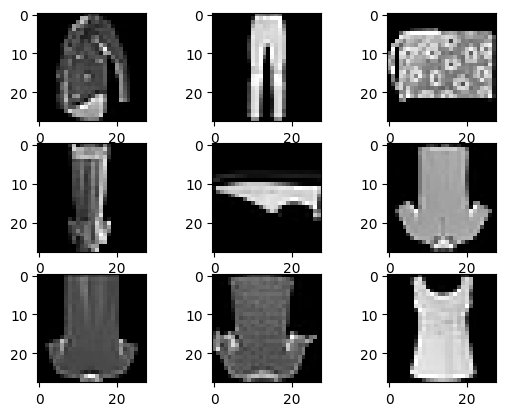

In [ ]:
# Guide Link For Data Augmentation using ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

# For random cropping
from keras.applications.inception_v3 import preprocess_input


# |LOADING DATA。。。。。。=========================================================================================================================
# load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)
# |LOADING DATA。。。。。。=========================================================================================================================




# Initialize ImageDataGenerator
# (Note that preprocess_input is for random cropping, check this link for guide: https://gist.github.com/rstml/bbd491287efc24133b90d4f7f3663905)
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                            preprocessing_function=preprocess_input)

# Fit the data generator on training data
datagen.fit(trainX)

# Perform Data Augmentation
# NOTE:seed is to keep the randomize fix so that every rerun is the same, can remove seed if u wan to see randomized data
train_generator = datagen.flow(trainX, batch_size=1,seed=123)
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_generator.next().squeeze(),cmap='gray')
pyplot.show()


In [ ]:
# For Color Jitter only changing brightness is available in ImageDataGenerator, if really want to do other like hue, saturation etc. can follow this guide
# https://stepup.ai/custom_data_augmentation_keras/

**MixUp Technique**  
$$
\tilde{x} = \lambda x_i + (1 - \lambda)x_j \\
\tilde{y} = \lambda y_i + (1 - \lambda)y_j \\
\text{Where $x_i$, $x_j$ are raw input vectors, $y_i$, $y_j$ are their corresponding 1-hot label encodings, and $\lambda \in [0, 1]$}
$$

**Key idea**: Linear interpolation of inputs should lead to linear interpolation of associated targets [1].

**References:**  
    [1] H. Zhang, M. Cisse, Y. N. Dauphin, and D. Lopez-Paz, “mixup: Beyond Empirical Risk Minimization,” arXiv.org, Oct. 25, 2017. https://arxiv.org/abs/1710.09412

(3, 28, 28)


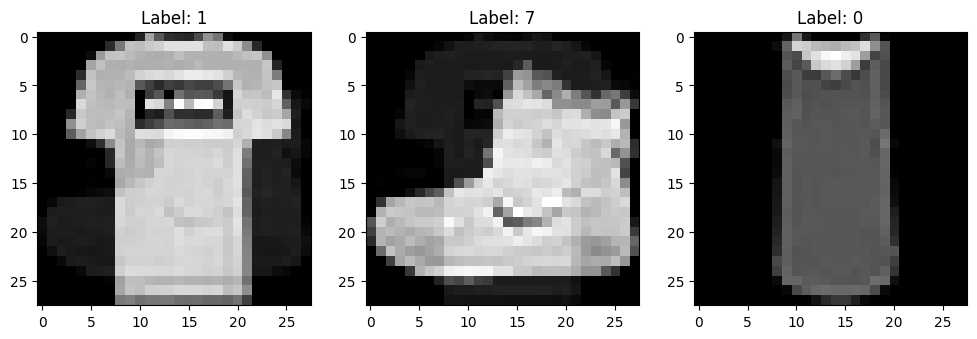

In [ ]:
import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

# # load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# # reshape dataset to have a single channel
# trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
# testX = testX.reshape((testX.shape[0], 28, 28, 1))
# # one hot encode target values
# trainY = to_categorical(trainY)
# testY = to_categorical(testY)

# Convert to tensors
trainX_t = torch.Tensor(trainX)
testX_t = torch.Tensor(testX)
trainY_t = torch.Tensor(trainY)
testY_t = torch.Tensor(testY)

trainingDataSet = TensorDataset(trainX_t, trainY_t)
testDataSet = TensorDataset(testX_t, testY_t)

train_dataloader1 = DataLoader(trainingDataSet, batch_size=64, shuffle=True)
train_dataloader2 = DataLoader(trainingDataSet, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testDataSet, batch_size=64, shuffle=True)

def mixup(images, labels, alpha):
  print(images.shape)
  lam = np.random.beta(alpha, alpha)
  batch_size, height, width = images.shape
  mixed_images = np.empty_like(images)
  mixed_labels = np.empty_like(labels)

  for i in range(len(images)):
    j = np.random.randint(batch_size)
    image1, label1 = images[i], labels[i]
    image2, label2 = images[j], labels[j]
    image = lam * image1 + (1 - lam) * image2
    label = lam * label1 + (1 - lam) * label2

    mixed_images[i] = image
    mixed_labels[i] = label

  return mixed_images, mixed_labels

mixup_images, mixup_labels = mixup(trainX[:3], trainY[:3], 2.5)

def display_images(images, labels):
    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.title(f"Label: {labels[i]}")
        plt.imshow(images[i], cmap='gray')
    plt.show()

display_images(mixup_images, mixup_labels)


alpha = 0.2 # Value of lambda is determined by alpha and the beta distribution
# During training:
# for (x1, y1), (x2, y2) in zip(train_dataloader1, train_dataloader2):
#   lam = np.random.beta(alpha, alpha)
#   x = lam * x1 + (1. - lam) * x2
#   y = lam * y1 + (1. - lam) * y2

  #optimizer.zero_grad()
  #loss(net(x), y).backward()
  #optimizer.step()

CUTMIX

In [ ]:
import matplotlib.pyplot as plt

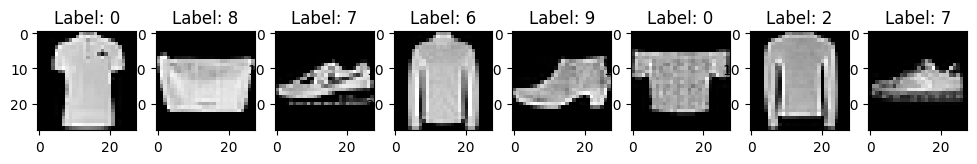

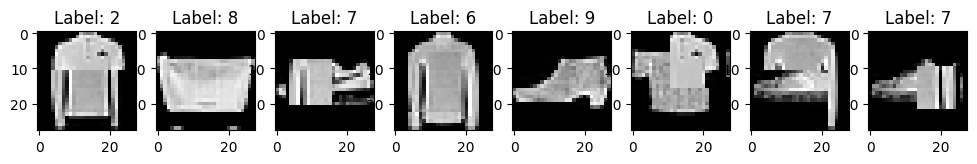

In [ ]:
def cutmix(images, labels, alpha):
    batch_size, height, width = images.shape

    # Initialize arrays to store mixed images and mixed labels
    mixed_images = np.empty_like(images)
    mixed_labels = np.empty_like(labels)

    for i in range(batch_size):
        # Randomly choose another image from the batch
        j = np.random.randint(batch_size)
        image1, label1 = images[i], labels[i]
        image2, label2 = images[j], labels[j]

        # Generate random lambda value from beta distribution
        lam = np.random.beta(alpha, alpha)

        # Compute the cutmix image
        max_cut_width = int(width * 1)
        cut_width = int(max_cut_width * np.sqrt(1 - lam))
        x1 = np.random.randint(0, width - cut_width)
        y1 = np.random.randint(0, height)
        x2 = x1 + cut_width
        y2 = y1 + cut_width

        mixed_image = image1.copy()
        mixed_image[y1:y2, x1:x2] = image2[y1:y2, x1:x2]

        count_label1 = np.count_nonzero(mixed_image == image1)
        count_label2 = np.count_nonzero(mixed_image == image2)

        if count_label1 >= count_label2:
            mixed_label = label1
        else:
            mixed_label = label2

        mixed_images[i] = mixed_image
        mixed_labels[i] = mixed_label

    return mixed_images, mixed_labels

#determines distribution of beta
alpha = 2.5
x=np.random.randint(1000)
#read only data
#conduct cutmix on batches of data
images_copy = trainX[x:x+8].copy()
labels_copy = trainy[x:x+8].copy()

cutmixed_images, cutmixed_labels = cutmix(images_copy, labels_copy, alpha)

def display_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.title(f"Label: {labels[i]}")
        plt.imshow(images[i], cmap='gray')
    plt.show()

# Display original and CutMix images
display_images(images_copy,labels_copy)
display_images(cutmixed_images, cutmixed_labels)